In [1]:
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Manipulate the device and the precision

**Question**

In PyTorch, each tensor has a `device` and a `dtype`. The `device` refers to the device on which the tensor is currently loaded. The `dtype` is the type of data stored in the tensor. By default, `device = torch.device("cpu")` and `dtype = torch.float32`.

One can build a tensor directly on a given device and with a given data type (or precision) by using the optional arguments `device` and `dtype`, or we can build them first with by-default values, and send copy them on the desired device with the desired precision with the `to` method.

Use both methods with devices `torch.device("cuda")` and `torch.device("cpu")` and with data types other than `torch.float32`.

In [2]:
datasets_path = # ...

with_cuda = False #torch.cuda.is_available()
if with_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
# Intialize a tensor directly on a device
x = torch.randn(5, device = device)
print(x)

# Intialize a tensor directly on a device with given precision
x = torch.randn(5, device = device, dtype = torch.float16)
print(x)

# Send an object to a device
x = torch.randn(5, device = device)
x = x.to(device = device)
print(x)
# Note: the object is first created on the CPU, then copied on the GPU
#    if it is not used on the CPU, this operation is suboptimal

# Send an object to a device with given precision
x = torch.randn(5)
x = x.to(device = device, dtype = torch.float16)
print(x)

tensor([-0.1363,  1.6265,  0.5494,  0.3032, -1.2023])
tensor([-1.8525,  0.0020, -1.9014, -1.0186,  0.0737], dtype=torch.float16)
tensor([-0.3831,  0.6554, -0.1151, -1.7444,  0.2078])
tensor([ 1.0215, -1.0332, -0.5967,  0.0336,  0.9536], dtype=torch.float16)


# Backpropagation of the gradient

## Introduction

Code libraries such as PyTorch, TensorFlow, JAX implement **automatic differentation (AutoDiff)** methods, which are at the core of ML methods trainable by gradient-based optimization techniques. These ML method include naturally neural networks.

AutoDiff is based on the construction of a computational graph, which is a *Directed Acyclic Graph* (DAG). This graph represents the different stages of computation of a function $f$ at a point $\boldsymbol{\theta} = (\theta_1, \theta_2, \cdots, \theta_S)$, and we want to compute: 
$$
\frac{\partial f}{\partial \theta_1}, \frac{\partial f}{\partial \theta_2}, \cdots, 
\frac{\partial f}{\partial \theta_S} .
$$
The DAG is then made of:
 * *directed* edges: represent the flows of data;
 * the root of the graph (a node which does not has any child): contains the (scalar) result of the computation of $f(\boldsymbol{\theta})$;
 * the leaf nodes (nodes which do not have any parent): contain the variables $(\theta_1, \theta_2, \cdots, \theta_S)$ with repect to which we want to differentiate $f$;
 * the non-leaf nodes: contain an operation to perform on their inputs.

In PyTorch, the leaf nodes are built either automatically when initializing a `torch.nn.Module` (such as a linear layer, in which weights and biases are by-default leaf nodes), or manually trough the class `torch.nn.Parameter`. Tensors that we use during a computation, but that are not variables of our function are just instances of the class `torch.Tensor` (with `requires_grad = False`).

The DAG is built on-the-fly during the successive operations, and the gradients are computed only when calling the `backward` method on the root node, or the function `torch.autograd.grad` on the root node and the leaf nodes with respect to which we want to differentiate. Using `backward` is very straightforward, while `torch.autograd.grad` is slightly more complex, but it supports advanced custom operations.

## Parameters and tensors

**Question 1**

Build some `torch.nn.Parameter`, some `torch.Tensor` and some `torch.Tensor` with `requires_grad = True`.

In [4]:
x1 = nn.Parameter(torch.randn(5))
x2 = nn.Parameter(torch.randn(1).squeeze())
a = torch.randn(5)
b = torch.randn(1).squeeze()
c = torch.randn(3, 4, requires_grad = True)

print(x1, "requires_grad:", x1.requires_grad)
print(x2, "requires_grad:", x2.requires_grad)
print(a, "requires_grad:", a.requires_grad)
print(b)
print(c)

Parameter containing:
tensor([ 0.4072, -1.3295, -0.3055, -1.0222,  1.0574], requires_grad=True) requires_grad: True
Parameter containing:
tensor(1.9660, requires_grad=True) requires_grad: True
tensor([-0.9121,  1.1328, -1.2622, -0.0960,  0.8719]) requires_grad: False
tensor(1.1258)
tensor([[-0.7159,  1.1954, -2.0856, -1.3799],
        [-0.8468, -1.0203,  0.2898,  0.8801],
        [ 0.8480, -0.6460, -0.4744, -1.1870]], requires_grad=True)


Note: The main difference between a `Parameter` and a `Tensor` with `requires_grad = True` is how they are managed inside a PyTorch `Module`. To avoid any unexpected behavior, one should prefer to use `Parameter`.

## Computing gradients

**Question 2**

Let $f$ be the function defined below. Compute its derivative with respect to `x1` and `x2` by using `backward`, and then by using `torch.autograd.grad`.

### backward

In [5]:
x1 = nn.Parameter(torch.randn(5))
x2 = nn.Parameter(torch.randn(1).squeeze())
a = torch.randn(5)
b = torch.randn(1).squeeze()

y = x2 * torch.sin((a * x1).sum() + b)

In [6]:
print(x1.grad, x2.grad)
y.backward()
print(x1.grad, x2.grad)

None None
tensor([-0.0010,  0.0258, -0.0242, -0.0190,  0.0124]) tensor(-0.9923)


/home/pwolinski/miniconda3/envs/pytorch/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


### torch.autograd.grad

In [7]:
x1 = nn.Parameter(torch.randn(5))
x2 = nn.Parameter(torch.randn(1).squeeze())
a = torch.randn(5)
b = torch.randn(1).squeeze()

y = x2 * torch.sin((a * x1).sum() + b)

In [8]:
grads = torch.autograd.grad(y, (x1, x2))
print("grad of x1:", grads[0])
print("grad of x2:", grads[1])

grad of x1: tensor([ 0.3556, -1.0077,  0.2780,  0.4267, -0.5709])
grad of x2: tensor(0.8219)


### Higher-order derivatives

**Question 3**

Compute $\frac{\partial f}{\partial x_1 \partial x_2}$ by using `torch.autograd.grad` twice. One check how to use the additional parameters `create_graph` and `allow_unused`.

In [9]:
x1 = nn.Parameter(torch.randn(5))
x2 = nn.Parameter(torch.randn(1).squeeze())
a = torch.randn(5)
b = torch.randn(1).squeeze()

y = x2 * torch.sin((a * x1).sum() + b)

In [10]:
grad_x1, grad_x2 = torch.autograd.grad(y, (x1, x2), create_graph = True)
print("grads:", grad_x1, grad_x2)
hessian_x2_x1 = torch.autograd.grad(grad_x2, (x1,), retain_graph = True, allow_unused = True)
print("hessian_x2_x1:", hessian_x2_x1)

grads: tensor([ 0.0250, -0.7845, -0.0393, -0.7373, -0.5732], grad_fn=<MulBackward0>) tensor(-0.7660, grad_fn=<MulBackward0>)
hessian_x2_x1: (tensor([ 0.0189, -0.5938, -0.0297, -0.5580, -0.4339]),)


## Access the computational graph

**Question 4**

The root node contains all the required information to perform the backpropagation and compute the derivatives. The graph and the nodes can be accessed with the methods `grad_fn` and `next_functions`. The leaf nodes can be accessed with the `variable` method. Before the backward, the intermediady results can be accessed with `_saved_self`.

Access the various nodes of the graph. 

In [11]:
x1 = nn.Parameter(torch.randn(5))
x2 = nn.Parameter(torch.randn(1).squeeze())
a = torch.randn(5)
b = torch.randn(1).squeeze()

y = x2 * torch.sin((a * x1).sum() + b)
y.backward()

print(y)
print(y.grad_fn)
print(y.grad_fn.next_functions)

tensor(-0.0559, grad_fn=<MulBackward0>)
((<AccumulateGrad object at 0x741b17979120>, 0), (<SinBackward0 object at 0x741b173d7b80>, 0))


In [12]:
x1 = nn.Parameter(torch.randn(5))
x2 = nn.Parameter(torch.randn(1).squeeze())
a = torch.randn(5)
b = torch.randn(1).squeeze()

y = x2 * torch.sin((a * x1).sum() + b)

print(y.grad_fn.next_functions[1][0]._saved_self)

y.backward()

print(y)
print(y.grad_fn)
print(y.grad_fn.next_functions)

print(y.grad_fn.next_functions[0][0].variable)
print(y.grad_fn.next_functions[1][0].next_functions)
print(y.grad_fn.next_functions[1][0].next_functions[0][0].next_functions)
print(y.grad_fn.next_functions[1][0].next_functions[0][0].next_functions[0][0].next_functions)

tensor(0.8798, grad_fn=<AddBackward0>)
tensor(-0.3804, grad_fn=<MulBackward0>)
((<AccumulateGrad object at 0x741b1737eb00>, 0), (<SinBackward0 object at 0x741c0ad37ee0>, 0))
Parameter containing:
tensor(-0.4937, requires_grad=True)
((<AddBackward0 object at 0x741b173967d0>, 0),)
((<SumBackward0 object at 0x741c0ad37ee0>, 0), (None, 0))
((<MulBackward0 object at 0x741b173d7e50>, 0),)


In [13]:
# Other example

x = nn.Parameter(torch.randn(6))
y = torch.split(x, 2)
z = sum(y).sum()
z.backward()

In [14]:
print(z.grad_fn.next_functions)
print(z.grad_fn.next_functions[0][0].next_functions)
print(z.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)

((<AddBackward0 object at 0x741b17215630>, 0),)
((<AddBackward0 object at 0x741b17215630>, 0), (<SplitBackward0 object at 0x741b17215780>, 2))
((<AddBackward0 object at 0x741b17215720>, 0), (<SplitBackward0 object at 0x741b17215780>, 1))


## Visualize the computational graph

**Question 5 (optional)**

Visualize the computational graph with the package `torchviz` (function `make_dot`).

In [15]:
from torchviz import make_dot

x1 = nn.Parameter(torch.randn(5))
x2 = nn.Parameter(torch.randn(1).squeeze())
a = torch.randn(5)
b = torch.randn(1).squeeze()

y = x2 * torch.sin((a * x1).sum() + b)

make_dot(y, {"x1": x1, "x2": x2})

ModuleNotFoundError: No module named 'torchviz'

## Forward-only mode

**Question 6**

Sometimes, for instance when testing a model, we are just interested in the result, and not the gradients. Such computations are more efficient if we are in a "forward-only" mode (in that situation, the computational graph is not created and the intermediary results are not stored).

The easiest way is to use `with torch.no_grad()`. One can also use the method `detach` on the parameters to use their content without building the computational graph.

Compute the function $f$ without building the computational graph using both methods and check that no computational graph is stored.

In [16]:
# with torch.no_grad()

x1 = nn.Parameter(torch.randn(5))
x2 = nn.Parameter(torch.randn(1).squeeze())
a = torch.randn(5)
b = torch.randn(1).squeeze()

with torch.no_grad(): # Faster computation when no gradient is needed
    y = x2 * torch.sin((a * x1).sum() + b)
    
print(y)

tensor(0.5674)


In [17]:
# detach()

x1 = nn.Parameter(torch.randn(5))
x2 = nn.Parameter(torch.randn(1).squeeze())
a = torch.randn(5)
b = torch.randn(1).squeeze()

y = x2.detach() * torch.sin((a * x1.detach()).sum() + b)

print(y)

tensor(0.0325)


# Managing a dataset

Before training a model on a dataset, we have to make some basic checks on the dataset and preprocess it correctly in order to obtain the best possible results (on a validation set).

## Checking a sample

First, we load MNIST.

In [19]:
batch_size = 64

# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    ]) 

# choose the training and test datasets
train_data = datasets.MNIST(datasets_path, train = True,
                              download = False, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = False, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

**Question 1**

By using `numpy.random.choice`, subplots and the function `imshow` of matplotlib, print 10 (or more) random data points of the training set (image + label).

Is the task feasible for a human? Do the data look clean ?

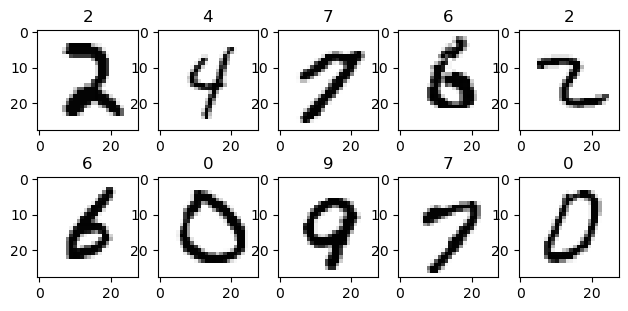

In [20]:
lst_idx = np.random.choice(train_size, 10, replace = False)

fig, ax = plt.subplots(2, 5, figsize = (7.5, 3.5))

for i, idx in enumerate(lst_idx):
    img, target = train_data[idx]
    ax[i//5, i%5].imshow(img.numpy().transpose(1, 2, 0), cmap="Greys")
    ax[i//5, i%5].set_title(classes[target])

## Check for class imbalance

**Question 2**

In classification tasks, it is common that the different classes are inequally represented in the dataset. If this "class imbalance" is too severe, the model is likely to fail to learn well the least represented classes.

Compute the number of data points in each class (in the training dataset). What do we observe?

In [21]:
ndata_per_class = 0

for data, target in train_loader:
    ndata_per_class += torch.bincount(target)
    
print(ndata_per_class)

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


Theoretical number of data points per class if the dataset was perfectly balanced: 6000.

# Managing a model

In [22]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.act_function = torch.tanh
        layers = [1, 6, 16, 120, 84, 10]

        self.conv1 = torch.nn.Conv2d(layers[0], layers[1], 5, padding = 2)
        self.conv2 = torch.nn.Conv2d(layers[1], layers[2], 5)
        self.fc1 = torch.nn.Linear(5 * 5 * layers[2], layers[3])
        self.fc2 = torch.nn.Linear(layers[3], layers[4])
        self.fc3 = torch.nn.Linear(layers[4], layers[5])


    def forward(self, x):
        x = self.conv1(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act_function(x)

        x = self.fc2(x)
        x = self.act_function(x)

        x = self.fc3(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)

        return x

**Question 1**

When a `torch.nn.Module` is created, its parameters and its submodules are automatically registered, which is necessary to optimize them with an `Optimizer`. One can access them with the methods `named_parameters`, `parameters`, `named_modules`, `modules`.

Access the various elements on an instance of LeNet.

In [23]:
model = LeNet()
print(list(model.named_parameters()))
print(list(model.parameters()))
print(list(model.named_modules()))
print(list(model.modules()))

[('conv1.weight', Parameter containing:
tensor([[[[ 0.0166,  0.0098,  0.1171,  0.1481,  0.1435],
          [-0.0837, -0.1061, -0.1612, -0.0802,  0.1040],
          [-0.1693,  0.1245,  0.0891,  0.0770,  0.0175],
          [-0.1351, -0.0190,  0.0285, -0.0528, -0.0789],
          [ 0.1020, -0.0441,  0.1122, -0.1009, -0.1253]]],


        [[[-0.1314, -0.0923,  0.1745,  0.1935, -0.1820],
          [ 0.0216,  0.0072, -0.1638, -0.0734, -0.1431],
          [-0.1728,  0.0815,  0.0791, -0.0109,  0.1700],
          [-0.1798, -0.0362, -0.1030, -0.0137, -0.1918],
          [-0.1276, -0.1142,  0.1038, -0.0566, -0.1313]]],


        [[[-0.0615,  0.1726,  0.0978,  0.1373, -0.1087],
          [-0.1577, -0.1407, -0.0050,  0.0577,  0.0962],
          [-0.0598,  0.1034,  0.0396,  0.0688,  0.1844],
          [ 0.0153, -0.0077, -0.1524, -0.0032, -0.1133],
          [ 0.1369,  0.0074,  0.0867, -0.0545, -0.1241]]],


        [[[-0.1310, -0.1092,  0.0953, -0.0348,  0.1947],
          [-0.1586,  0.0826,  0.0830

**Question 2**

Create an instance of the class below and print its modules and parameters. What do we observe? Fix this issue by using the object `torch.nn.ModuleList`.

In [24]:
class SomeModel(nn.Module):
    def __init__(self):
        super(SomeModel, self).__init__()

        self.layers = [torch.nn.Linear(5, 5),
                      torch.nn.ReLU(),
                      torch.nn.Linear(5, 1)]

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [25]:
some_model = SomeModel()
print(list(some_model.named_parameters()))
print(list(some_model.parameters()))
print(list(some_model.named_modules()))
print(list(some_model.modules()))

[]
[]
[('', SomeModel())]
[SomeModel()]


In [26]:
class SomeModelFixed(nn.Module):
    def __init__(self):
        super(SomeModelFixed, self).__init__()

        self.layers = nn.ModuleList([torch.nn.Linear(5, 5),
                      torch.nn.ReLU(),
                      torch.nn.Linear(5, 1)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [27]:
some_model = SomeModelFixed()
print(list(some_model.named_parameters()))
print(list(some_model.parameters()))
print(list(some_model.named_modules()))
print(list(some_model.modules()))

[('layers.0.weight', Parameter containing:
tensor([[-0.3557,  0.2064,  0.3078, -0.1833,  0.1075],
        [-0.3880, -0.0510,  0.4237,  0.0250,  0.2725],
        [-0.3423,  0.3546,  0.3932, -0.1455, -0.2228],
        [-0.2960, -0.0474,  0.0858,  0.1520,  0.1151],
        [-0.1502,  0.4360, -0.1503, -0.1928,  0.1469]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([ 0.2585, -0.1512,  0.1303, -0.0894, -0.0190], requires_grad=True)), ('layers.2.weight', Parameter containing:
tensor([[ 0.1877,  0.1054, -0.1832,  0.3872,  0.0706]], requires_grad=True)), ('layers.2.bias', Parameter containing:
tensor([-0.0975], requires_grad=True))]
[Parameter containing:
tensor([[-0.3557,  0.2064,  0.3078, -0.1833,  0.1075],
        [-0.3880, -0.0510,  0.4237,  0.0250,  0.2725],
        [-0.3423,  0.3546,  0.3932, -0.1455, -0.2228],
        [-0.2960, -0.0474,  0.0858,  0.1520,  0.1151],
        [-0.1502,  0.4360, -0.1503, -0.1928,  0.1469]], requires_grad=True), Parameter containing:
t

**Question 3 (optional)**

Check out the method `register_buffer` of `Module`, explain why it can be useful and show a use-case.

# Training a model

## Basic training

**Question 1**

We want to train LeNet on MNIST. Fill the blanks in the following pieces of code.

Wrap the training process into a function.

In [29]:
def train_model(model, criterion, optimizer, nepochs):
    #List to store loss to visualize
    valid_loss_min = np.inf # track change in validation loss

    train_losses = []
    test_losses = []
    acc_eval = []
    #test_counter = [i*len(train_loader.dataset) for i in n_epochs]

    for epoch in range(nepochs):
        # keep track of training and validation loss
        train_loss = 0.
        valid_loss = 0.

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device = device)
            target = target.to(device = device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        correct = 0
        for data, target in test_loader:
            with torch.no_grad():
                data = data.to(device = device)
                target = target.to(device = device)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)

                # calculate the batch loss
                loss = criterion(output, target)

                # update average validation loss 
                valid_loss += loss.item()*data.size(0)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        acc_eval.append(correct/len(test_loader.dataset)*100)
        train_losses.append(train_loss)
        test_losses.append(valid_loss)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

In [30]:
# model
model = LeNet().to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

nepochs = 5

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 1.675757 	Validation Loss: 0.748479
Epoch: 1 	Training Loss: 0.506517 	Validation Loss: 0.350556
Epoch: 2 	Training Loss: 0.303011 	Validation Loss: 0.240242
Epoch: 3 	Training Loss: 0.221030 	Validation Loss: 0.182419
Epoch: 4 	Training Loss: 0.173921 	Validation Loss: 0.146838


## Data normalization

**Question 2**

To make sure that the inputs of the neural network are within a controlled range, we usually transform the dataset to be sure that the data are centered with variance 1. It is not always necessary, but it is worth knowing it.

Check the range of values on a sample of MNIST. Compute the mean and the standard deviation of the training dataset of MNIST and normalize the dataset accordingly by using `transforms.Normalize`.

In [31]:
mean = 0

total_sum = 0
for data, target in train_loader:
    total_sum += data.sum()
mean = total_sum / (28**2 * len(train_loader.dataset))

total_var = 0
for data, target in train_loader:
    total_var += (data - mean).pow(2).sum()
std = (total_var / (28**2 * len(train_loader.dataset))).sqrt()

print(mean, std)

tensor(0.1307) tensor(0.3081)


In [32]:
batch_size = 64

# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ]) 

# choose the training and test datasets
train_data = datasets.MNIST(datasets_path, train = True,
                              download = True, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = True, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

## Data augmentation

**Question 3**

It is very common to face overfitting when doing deep learning. So, several methods can be used to solve this problem. One of them is called "data augmentation". It consists in adding "noise" to data points of the training dataset in order to make the model resistant to small changes of the data. 

When training on images, it is common to perform "random crops", "random flips", and small "random rotations". With MNIST, it is meaningless to add random flips, because most digits are not supposed to be invariant by vertical or horizontal symmetries.

Add random crops with `transforms.RandomCrop` with a reasonable number of pixels to the transforms to do on the dataset, visualize the resulting images and train the model.

In [33]:
batch_size = 64

# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomCrop(28, padding = 3)
    ]) 

# choose the training and test datasets
train_data = datasets.MNIST(datasets_path, train = True,
                              download = True, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = True, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

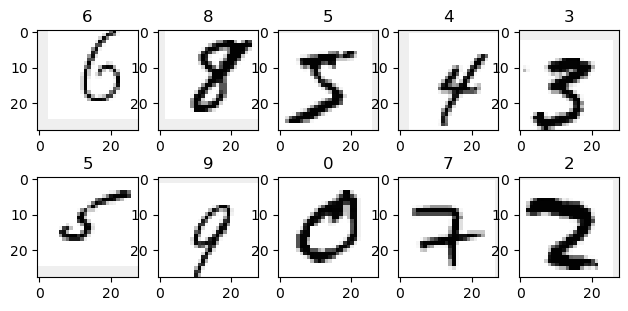

In [34]:
lst_idx = np.random.choice(64, 10, replace = False)

fig, ax = plt.subplots(2, 5, figsize = (7.5, 3.5))

for data, target in train_loader:
    for i, idx in enumerate(lst_idx):
        img, tgt = data[idx], target[idx]
        ax[i//5, i%5].imshow(img.numpy().transpose(1, 2, 0), cmap="Greys")
        ax[i//5, i%5].set_title(classes[tgt])
    break

In [35]:
# model
model = LeNet().to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

nepochs = 5

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 1.933978 	Validation Loss: 1.378455
Epoch: 1 	Training Loss: 1.104678 	Validation Loss: 0.802460
Epoch: 2 	Training Loss: 0.584697 	Validation Loss: 0.405548
Epoch: 3 	Training Loss: 0.339450 	Validation Loss: 0.267051
Epoch: 4 	Training Loss: 0.249938 	Validation Loss: 0.205249


## Influence of the initialization

**Question 4**

Build a Multilayer Perceptron with ReLU activation functions, which takes 3 arguments: 
 * `layers`: the list of layer sizes;
 * `sigma_w`: the standard deviation chosen for initializing the weights;
 * `with_scaling`: if True, we multiply the generated weights by $1/\sqrt{\# \text{inputs}}$.

Write the `reset_parameters` method, which initialize the weights according to a Gaussian distribution, either with variance $\sigma_w^2$, or $\sigma_w^2/\# \text{inputs}$.

In [36]:
class Perceptron(torch.nn.Module):
    def __init__(self, layers, sigma_w, scaling = False):
        super(Perceptron, self).__init__()

        self.act_function = torch.relu
        self.scaling = scaling
        self.sigma_w = sigma_w

        self.layers = torch.nn.ModuleList()
        for l_in, l_out in zip(layers[:-1], layers[1:]):
            self.layers.append(nn.Linear(l_in, l_out))
        self.nb_layers = len(self.layers)

        self.reset_parameters()

    def reset_parameters(self):
        with torch.no_grad():
            for i, l in enumerate(self.layers):
                l.weight.data.normal_()
                l.weight.data.mul_(self.sigma_w)
                
                if self.scaling:
                    l.weight.data.div_(np.sqrt(l.weight.size(1)))
                    
                l.bias.data.zero_()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers[:-1]:
            x = l(x)
            x = self.act_function(x)
                                       
        x = self.layers[-1](x)
        x = torch.nn.functional.log_softmax(x, dim = 1)

        return x

**Question 4**

Train the model with various choices of initialization (which ones?) and try various numbers of layers with various widths.

In [37]:
# model
model = Perceptron([28**2, 100, 50, 10], 0).to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

nepochs = 5

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 2.301863 	Validation Loss: 2.301313
Epoch: 1 	Training Loss: 2.301321 	Validation Loss: 2.301091
Epoch: 2 	Training Loss: 2.301232 	Validation Loss: 2.301045
Epoch: 3 	Training Loss: 2.301216 	Validation Loss: 2.301033
Epoch: 4 	Training Loss: 2.301213 	Validation Loss: 2.301030


In [38]:
# model
model = Perceptron([28**2, 100, 50, 10], np.sqrt(2), True).to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

nepochs = 5

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 1.120220 	Validation Loss: 0.665494
Epoch: 1 	Training Loss: 0.551310 	Validation Loss: 0.453000
Epoch: 2 	Training Loss: 0.407433 	Validation Loss: 0.361835
Epoch: 3 	Training Loss: 0.346228 	Validation Loss: 0.311518
Epoch: 4 	Training Loss: 0.302627 	Validation Loss: 0.280478


In [39]:
# model
model = Perceptron([28**2, 100, 50, 10], np.sqrt(2), False).to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

nepochs = 5

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 29.924207 	Validation Loss: 2.869874
Epoch: 1 	Training Loss: 2.696083 	Validation Loss: 2.508532
Epoch: 2 	Training Loss: 2.453636 	Validation Loss: 2.371809
Epoch: 3 	Training Loss: 2.428252 	Validation Loss: 2.393013
Epoch: 4 	Training Loss: 2.377721 	Validation Loss: 2.343491


In [40]:
# model
model = Perceptron([28**2, 100, 100, 10, 100, 50, 10], .1, False).to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

nepochs = 5

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 2.115622 	Validation Loss: 1.761019
Epoch: 1 	Training Loss: 1.293322 	Validation Loss: 1.012153
Epoch: 2 	Training Loss: 0.827263 	Validation Loss: 0.662592
Epoch: 3 	Training Loss: 0.610450 	Validation Loss: 0.538347
Epoch: 4 	Training Loss: 0.495704 	Validation Loss: 0.459998


In [41]:
# model
model = Perceptron([28**2, 100, 100, 10, 100, 50, 10], 1.4, True).to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

nepochs = 5

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 1.297253 	Validation Loss: 0.657036
Epoch: 1 	Training Loss: 0.547711 	Validation Loss: 0.485779
Epoch: 2 	Training Loss: 0.407126 	Validation Loss: 0.399306
Epoch: 3 	Training Loss: 0.342990 	Validation Loss: 0.348774
Epoch: 4 	Training Loss: 0.301646 	Validation Loss: 0.290041


**Question 5 (optional)**

Implement the NTK parameterization in the `Perceptron` model: divide by $1/\sqrt{\# \text{inputs}}$ the result of each layer.

Train such a network with the SGD (with `scaling = False`) with learning rates of order $1$.

# Adam

**Question 6**

Train LeNet with the SGD and Adam with default parameters and compare.

In [42]:
# model
model = LeNet().to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters())

nepochs = 5

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 0.382929 	Validation Loss: 0.150886
Epoch: 1 	Training Loss: 0.121737 	Validation Loss: 0.109628
Epoch: 2 	Training Loss: 0.095810 	Validation Loss: 0.095509
Epoch: 3 	Training Loss: 0.083188 	Validation Loss: 0.076180
Epoch: 4 	Training Loss: 0.075783 	Validation Loss: 0.061905


In [43]:
# model
model = LeNet().to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr = .01)

nepochs = 5

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 1.784894 	Validation Loss: 1.275867
Epoch: 1 	Training Loss: 0.980806 	Validation Loss: 0.665495
Epoch: 2 	Training Loss: 0.516080 	Validation Loss: 0.388775
Epoch: 3 	Training Loss: 0.338161 	Validation Loss: 0.270794
Epoch: 4 	Training Loss: 0.265009 	Validation Loss: 0.219891


## Other stuff

**Additional questions**

 * explore data augmentation with the dataset CIFAR-10
 * test different batch sizes. How to change the learning rate when we change the batch size?
 * test drop-out layers
 * read the documentation on SGD and Adam an propose a way to assign different learning rates to different sets of parameters

# Saving and loading a model

When training a model, it is a good practice to make checkpoints every few epochs. That is, store the current state of the model **and the optimizer**. Doing so, we are able to reload the current state of a training process if:
 * the training has been interrupted for an unknown reason (which occurs when using a cluster);
 * we want to diagnose an issue with the model at an early stage (drop of performance, instabilities of the loss, etc.).

It is essential to save the current state of the optimizer, since it contains frequently information acquired during the early stages of training (momentum with SGD + momentum, running means and moments with Adam).

Above all, we define again a model to train and a training process.

In [44]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.act_function = torch.tanh
        layers = [1, 6, 16, 120, 84, 10]

        self.conv1 = torch.nn.Conv2d(layers[0], layers[1], 5, padding = 2)
        self.conv2 = torch.nn.Conv2d(layers[1], layers[2], 5)
        self.fc1 = torch.nn.Linear(5 * 5 * layers[2], layers[3])
        self.fc2 = torch.nn.Linear(layers[3], layers[4])
        self.fc3 = torch.nn.Linear(layers[4], layers[5])


    def forward(self, x):
        x = self.conv1(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.act_function(x)
        x = torch.nn.functional.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act_function(x)

        x = self.fc2(x)
        x = self.act_function(x)

        x = self.fc3(x)
        x = torch.nn.functional.log_softmax(x, dim = 1)

        return x

In [45]:
mean, std = .1307, .3081
batch_size = 64

# build transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ]) 

# choose the training and test datasets
train_data = datasets.MNIST(datasets_path, train = True,
                              download = False, transform = transform)
test_data = datasets.MNIST(datasets_path, train=False,
                             download = False, transform = transform)

train_size = len(train_data)
test_size = len(test_data)

# build the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = False)

# specify the image classes
classes = [f"{i}" for i in range(10)]

In [46]:
# Initial version of train_model

def train_model(model, criterion, optimizer, nepochs):
    #List to store loss to visualize
    valid_loss_min = np.inf # track change in validation loss

    train_losses = []
    test_losses = []
    acc_eval = []
    #test_counter = [i*len(train_loader.dataset) for i in n_epochs]

    for epoch in range(nepochs):
        # keep track of training and validation loss
        train_loss = 0.
        valid_loss = 0.

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device = device)
            target = target.to(device = device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        correct = 0
        for data, target in test_loader:
            with torch.no_grad():
                data = data.to(device = device)
                target = target.to(device = device)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)

                # calculate the batch loss
                loss = criterion(output, target)

                # update average validation loss 
                valid_loss += loss.item()*data.size(0)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        acc_eval.append(correct/len(test_loader.dataset)*100)
        train_losses.append(train_loss)
        test_losses.append(valid_loss)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

**Question 1**

Add lines of code to the function `train_model` to store both the model and the optimizer. One can use `torch.save` and the methods `state_dict` of `Module` and `Optimizer`. Note: one can use `torch.save` to save any PyTorch object **and** any native Python object, such as `dict`.

Add options to `train_model` to resume training from a specific checkpoint.

Launch a training with Adam, stop it, and then resume it.

In [47]:
def train_model(model, criterion, optimizer, nepochs, save_path = None,
               load_path = None):
    #List to store loss to visualize
    train_losses = []
    test_losses = []
    acc_eval = []
    start_epoch = 0
    
    if load_path is not None:
        checkpoint = torch.load(load_path, weights_only = False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint["epoch"] + 1
        acc_eval = checkpoint["acc_eval"]
        train_losses = checkpoint["train_losses"]
        test_losses = checkpoint["test_losses"]

    for epoch in range(start_epoch, nepochs):
        # keep track of training and validation loss
        train_loss = 0.
        valid_loss = 0.

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device = device)
            target = target.to(device = device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        correct = 0
        for data, target in test_loader:
            with torch.no_grad():
                data = data.to(device = device)
                target = target.to(device = device)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)

                # calculate the batch loss
                loss = criterion(output, target)

                # update average validation loss 
                valid_loss += loss.item()*data.size(0)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        acc_eval.append(correct/len(test_loader.dataset)*100)
        train_losses.append(train_loss)
        test_losses.append(valid_loss)
        
        # Save
        if save_path is not None:
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "acc_eval": acc_eval,
                "train_losses": train_losses,
                "test_losses": test_losses
            }, save_path)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

In [48]:
# model
model = LeNet().to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters())

nepochs = 3

train_model(model, criterion, optimizer, nepochs, save_path = "checkpoint.pkl")

Epoch: 0 	Training Loss: 0.221681 	Validation Loss: 0.097727
Epoch: 1 	Training Loss: 0.066561 	Validation Loss: 0.066933
Epoch: 2 	Training Loss: 0.045085 	Validation Loss: 0.060652


In [49]:
# model
model = LeNet().to(device = device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters())

nepochs = 5

train_model(model, criterion, optimizer, nepochs, load_path = "checkpoint.pkl")

Epoch: 3 	Training Loss: 0.033534 	Validation Loss: 0.058244
Epoch: 4 	Training Loss: 0.025514 	Validation Loss: 0.052174


**Question 2**

Define a model and a Adam optimizer attached to it. Train them for a few epochs, then examine their `state_dict` and compare it to their complete list of attributes (by using the `vars` function or the attribute `__dict__`). Are all the attributes stored?

Examine `optimizer.state`.

In [50]:
model = LeNet().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
nepochs = 1

train_model(model, criterion, optimizer, nepochs)

Epoch: 0 	Training Loss: 0.214726 	Validation Loss: 0.075817


In [51]:
model.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])

In [52]:
optimizer.state_dict().keys()

dict_keys(['state', 'param_groups'])

In [53]:
optimizer.__dict__.keys()

dict_keys(['defaults', '_optimizer_step_pre_hooks', '_optimizer_step_post_hooks', '_optimizer_state_dict_pre_hooks', '_optimizer_state_dict_post_hooks', '_optimizer_load_state_dict_pre_hooks', '_optimizer_load_state_dict_post_hooks', '_zero_grad_profile_name', 'state', 'param_groups', '_warned_capturable_if_run_uncaptured'])

In [54]:
optimizer.defaults

{'lr': 0.001,
 'betas': (0.9, 0.999),
 'eps': 1e-08,
 'weight_decay': 0,
 'amsgrad': False,
 'maximize': False,
 'foreach': None,
 'capturable': False,
 'differentiable': False,
 'fused': None}

In [55]:
optimizer.state

defaultdict(dict,
            {Parameter containing:
             tensor([[[[ 1.2111e-01, -6.4034e-02,  3.1799e-02, -4.7571e-02, -2.6972e-01],
                       [ 1.3388e-01,  2.4175e-02, -3.9812e-02, -2.0724e-01, -2.1764e-01],
                       [-8.8096e-02,  1.5533e-01, -7.5839e-05, -2.0076e-01, -1.1777e-01],
                       [-8.0312e-03,  6.6289e-02, -4.4284e-02, -2.5540e-01,  1.3134e-02],
                       [-9.2619e-02,  1.5221e-01, -7.4998e-02, -1.9236e-01, -6.2910e-02]]],
             
             
                     [[[ 2.3816e-01, -3.9617e-02,  1.8663e-01,  1.7814e-02,  1.3682e-01],
                       [ 1.5346e-01,  3.9953e-02,  1.5768e-01,  1.1038e-01,  1.9835e-01],
                       [-1.1521e-01, -2.9974e-02, -1.5184e-01,  1.0774e-01,  7.9503e-02],
                       [-1.1507e-01, -1.9940e-01,  1.1349e-01, -6.1508e-02, -1.8455e-01],
                       [-1.0082e-01, -5.0745e-02,  5.2754e-02,  4.1347e-02, -2.1872e-01]]],
             
 

To store data related to the training that are not automatically registered in `state_dict`, one can add them manually to the object to store. For attributes of the model or the optimizer, either they do not change during training, so it is not necessary to store them, or they change, and it is desirable to change them into `Parameter` and register them by using `self.register_parameter`.

**Quesion 3 (optional)**

When we want to ensure reproducibility, we set manually the seed of the Random Number Generator (RNG) of PyTorch with `torch.manual_seed`. When performing two trainings with the same seed, the trained models will be exactly the same.

Test two trainings with the same seed.

When using checkpoints, to ensure reproducibility, one has to store the state of the RNG (of CPU RNG and/or CUDA RNG). This can be done with `torch.get_rng_state()` and `torch.cuda.get_rng_state()`. Also, `torch.backends.cudnn.deterministic = True` can help.

Change the save/load procedure to ensure reproducibility even with checkpoints.

In [61]:
def train_model(model, criterion, optimizer, nepochs, save_path = None,
               load_path = None):
    #List to store loss to visualize
    train_losses = []
    test_losses = []
    acc_eval = []
    start_epoch = 0
    
    if load_path is not None:
        checkpoint = torch.load(load_path, weights_only = False)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint["epoch"] + 1
        acc_eval = checkpoint["acc_eval"]
        train_losses = checkpoint["train_losses"]
        test_losses = checkpoint["test_losses"]
        torch.set_rng_state(checkpoint["rng_state"])
        if with_cuda:
            torch.cuda.set_rng_state(checkpoint["cuda_rng_state"])

    for epoch in range(start_epoch, nepochs):
        # keep track of training and validation loss
        train_loss = 0.
        valid_loss = 0.

        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device = device)
            target = target.to(device = device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()

            # perform a single optimization step (parameter update)
            optimizer.step()

            # update training loss
            train_loss += loss.item() * data.size(0)

        ######################    
        # validate the model #
        ######################
        model.eval()
        correct = 0
        for data, target in test_loader:
            with torch.no_grad():
                data = data.to(device = device)
                target = target.to(device = device)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)

                # calculate the batch loss
                loss = criterion(output, target)

                # update average validation loss 
                valid_loss += loss.item()*data.size(0)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(test_loader.dataset)
        acc_eval.append(correct/len(test_loader.dataset)*100)
        train_losses.append(train_loss)
        test_losses.append(valid_loss)
        
        # Save
        if save_path is not None:
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "acc_eval": acc_eval,
                "train_losses": train_losses,
                "test_losses": test_losses,
                "rng_state": torch.get_rng_state(),
                "cuda_rng_state": torch.cuda.get_rng_state() if with_cuda else None
            }, save_path)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

In [62]:
#device = torch.device("cpu")
if with_cuda:
    torch.backends.cudnn.deterministic = True

model = LeNet().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
nepochs = 1

train_model(model, criterion, optimizer, nepochs, save_path = "checkpoint.pkl")

Epoch: 0 	Training Loss: 0.214411 	Validation Loss: 0.073278


In [63]:
model = LeNet().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
nepochs = 4

train_model(model, criterion, optimizer, nepochs, load_path = "checkpoint.pkl")

Epoch: 1 	Training Loss: 0.061066 	Validation Loss: 0.050335
Epoch: 2 	Training Loss: 0.040765 	Validation Loss: 0.049560
Epoch: 3 	Training Loss: 0.029245 	Validation Loss: 0.054061


In [64]:
model = LeNet().to(device = device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
nepochs = 4

train_model(model, criterion, optimizer, nepochs, load_path = "checkpoint.pkl")

Epoch: 1 	Training Loss: 0.061066 	Validation Loss: 0.050335
Epoch: 2 	Training Loss: 0.040765 	Validation Loss: 0.049560
Epoch: 3 	Training Loss: 0.029245 	Validation Loss: 0.054061


# Forward/backward hooks

To help debugging, it is possible to use forward and backward hooks. They are functions that the user can define and register into a module in order to call them during the forward/backward pass.

**Question**

Use the method `register_forward_hook` on a submodule (for instance `fc3`) of `model` to print the input and the output of the layer at each pass.

For the backward, use `register_full_backward_hook` to print the gradients according to the output and to the input.

In [65]:
model = LeNet().to(device = device)
optimizer = optim.Adam(model.parameters())

In [66]:
def hook(module, input, output):
    print("=== FORWARD ===")
    print("module:", module)
    print("input:", input)
    print("output:", output)

model.fc3.register_forward_hook(hook)

In [67]:
for data, target in test_loader:
    with torch.no_grad():
        data = data.to(device = device)
        target = target.to(device = device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the batch loss
        loss = criterion(output, target)
        break

=== FORWARD ===
module: Linear(in_features=84, out_features=10, bias=True)
input: (tensor([[-0.1850,  0.0130, -0.0162,  ..., -0.0356, -0.1693,  0.0188],
        [-0.1382,  0.0142,  0.0050,  ..., -0.0167, -0.2115, -0.1005],
        [-0.0450,  0.0172,  0.0338,  ...,  0.1435, -0.1974, -0.0749],
        ...,
        [-0.1050, -0.0192, -0.0201,  ..., -0.1139, -0.2045, -0.0720],
        [-0.1691,  0.0025,  0.0037,  ...,  0.0588, -0.1763, -0.1052],
        [-0.1117,  0.0422, -0.0276,  ...,  0.0561, -0.2093, -0.0418]]),)
output: tensor([[-3.3657e-02, -2.1945e-02, -1.0510e-01, -8.1433e-02, -4.6607e-02,
          3.6759e-02,  1.4856e-01,  6.4578e-03,  1.6736e-01,  1.2749e-01],
        [-5.6749e-02, -1.7369e-02,  4.3454e-02, -1.3543e-02, -4.2700e-02,
          9.9895e-02,  1.6199e-02, -3.6899e-02,  2.7296e-02,  9.3829e-02],
        [-5.0294e-02, -4.5394e-02,  1.0838e-02, -1.4505e-02, -7.9504e-02,
          5.4853e-02,  8.3862e-02,  6.1071e-02,  1.8331e-01,  1.0990e-01],
        [-4.0687e-02, -1.1

In [68]:
def backhook(module, grad_input, grad_output):
    print("=== BACKWARD ===")
    print("module:", module)
    print("input:", grad_input)
    print("output:", grad_output)

model.fc3.register_full_backward_hook(backhook)

for data, target in test_loader:
    optimizer.zero_grad()
    data = data.to(device = device)
    target = target.to(device = device)

    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)

    # calculate the batch loss
    loss = criterion(output, target)
    loss.backward()
    break

=== FORWARD ===
module: Linear(in_features=84, out_features=10, bias=True)
input: (tensor([[-0.1850,  0.0130, -0.0162,  ..., -0.0356, -0.1693,  0.0188],
        [-0.1382,  0.0142,  0.0050,  ..., -0.0167, -0.2115, -0.1005],
        [-0.0450,  0.0172,  0.0338,  ...,  0.1435, -0.1974, -0.0749],
        ...,
        [-0.1050, -0.0192, -0.0201,  ..., -0.1139, -0.2045, -0.0720],
        [-0.1691,  0.0025,  0.0037,  ...,  0.0588, -0.1763, -0.1052],
        [-0.1117,  0.0422, -0.0276,  ...,  0.0561, -0.2093, -0.0418]],
       grad_fn=<BackwardHookFunctionBackward>),)
output: tensor([[-3.3657e-02, -2.1945e-02, -1.0510e-01, -8.1433e-02, -4.6607e-02,
          3.6759e-02,  1.4856e-01,  6.4578e-03,  1.6736e-01,  1.2749e-01],
        [-5.6749e-02, -1.7369e-02,  4.3454e-02, -1.3543e-02, -4.2700e-02,
          9.9895e-02,  1.6199e-02, -3.6899e-02,  2.7296e-02,  9.3829e-02],
        [-5.0294e-02, -4.5394e-02,  1.0838e-02, -1.4505e-02, -7.9504e-02,
          5.4853e-02,  8.3862e-02,  6.1071e-02,  1.833